<a href="https://colab.research.google.com/github/rafaelcarvalho7/Alura_Challenge_DS_PySpark/blob/main/Notebooks/ChallengeDataScience_Semana01_RafaelCarvalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalando o PySpark

In [1]:
#Instalando o PySpark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('ChallengeDS_InsightPlaces') \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
get_ipython().system_raw('./ngrok http 4050 &')

In [7]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


In [8]:
spark

# Imobiliária Insight Places

## Importando Dados

In [9]:
import zipfile
zipfile.ZipFile('/content/drive/MyDrive/ChallengeDS_IP/semana-1.zip', 'r').extractall('/content/drive/MyDrive/ChallengeDS_IP')

In [10]:
path = '/content/drive/MyDrive/ChallengeDS_IP/dataset_bruto.json'
imoveisRJ = spark.read.json(path)

In [11]:
imoveisRJ.count()

89083

## Analisando os dados

###Verificando conjunto de dados

In [12]:
imoveisRJ.head()

Row(anuncio=Row(andar=0, area_total=[], area_util=['16'], banheiros=[0], caracteristicas=[], endereco=Row(bairro='Centro', cep='20061003', cidade='Rio de Janeiro', estado='Rio de Janeiro', latitude=-22.906082, longitude=-43.18671, pais='BR', rua='Rua Buenos Aires', zona='Zona Central'), id='47d553e0-79f2-4a46-9390-5a3c962740c2', quartos=[0], suites=[0], tipo_anuncio='Usado', tipo_unidade='Outros', tipo_uso='Comercial', vaga=[1], valores=[Row(condominio='260', iptu='107', tipo='Venda', valor='10000')]), imagens=[Row(id='39d6282a-71f3-47bc-94aa-909351ecd881', url='https://api.images.insightplaces.com.br/{type}/{width}/{height}/1b08098d-f2dc-439c-b604-a4e50d12774b.jpg')], usuario=Row(id='9d44563d-3405-4e84-9381-35b7cf40a9a4', nome='Frank'))

In [13]:
imoveisRJ.printSchema()

root
 |-- anuncio: struct (nullable = true)
 |    |-- andar: long (nullable = true)
 |    |-- area_total: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- area_util: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- banheiros: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- caracteristicas: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- endereco: struct (nullable = true)
 |    |    |-- bairro: string (nullable = true)
 |    |    |-- cep: string (nullable = true)
 |    |    |-- cidade: string (nullable = true)
 |    |    |-- estado: string (nullable = true)
 |    |    |-- latitude: double (nullable = true)
 |    |    |-- longitude: double (nullable = true)
 |    |    |-- pais: string (nullable = true)
 |    |    |-- rua: string (nullable = true)
 |    |    |-- zona: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-

Alterar valores:\
⇒ area_total = string->double\
⇒ area_util = string->double\
⇒ valores.condiminio = string->double\
⇒ valores.iptu = string->double\
⇒ valores.valor = string->double


### Convertendo StringType para DoubleType

In [14]:
from pyspark.sql.functions import from_json, col, concat_ws
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.sql import functions as f

In [15]:
#Selcionando só a coluna de anuncios
imoveisRJ_anuncio = imoveisRJ.select("anuncio.*")
imoveisRJ_anuncio.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- area_util: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- banheiros: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- endereco: struct (nullable = true)
 |    |-- bairro: string (nullable = true)
 |    |-- cep: string (nullable = true)
 |    |-- cidade: string (nullable = true)
 |    |-- estado: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |    |-- pais: string (nullable = true)
 |    |-- rua: string (nullable = true)
 |    |-- zona: string (nullable = true)
 |-- id: string (nullable = true)
 |-- quartos: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- suites: array (nullable = true)
 |    |-- element: long (c

In [16]:
imoveisRJ_anuncio.show(15, truncate=False)

+-----+----------+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-----------+----+----------------------------+
|andar|area_total|area_util|banheiros|caracteristicas                                                                                                                |endereco                                                                                                                     |id                                  |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|valores                     |
+-----+----------+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+

In [17]:
colunas_corrigir = ['area_total', 'area_util', 'banheiros', 'quartos', 'suites', 'vaga']

In [18]:
# Tranformando as variáveis de array para seu determinado tipo
imoveisRJ_anuncio_corr = imoveisRJ_anuncio.select([f.col(c)[0].alias(c) if c in colunas_corrigir else c for c in imoveisRJ_anuncio.columns])
imoveisRJ_anuncio_corr.show()

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    0|      null|       16|        0|                  []|{Centro, 20061003...|47d553e0-79f2-4a4...|      0|     0|       Usado|      Outros|  Comercial|   1|[{260, 107, Venda...|
|    0|      null|       14|        0|                  []|{Centro, 20051040...|b6ffbae1-17f6-487...|      0|  null|       Usado|      Outros|  Comercial|   0|[{260, 107, Venda...|
|    0|      1026|     1026|        0|                  []|{Maria da Graça, ...|1fb030a5-9e3e-4

In [19]:
imoveisRJ_anuncio_corr.limit(10).toPandas()

,andar,area_total,area_util,banheiros,caracteristicas,endereco,id,quartos,suites,tipo_anuncio,tipo_unidade,tipo_uso,vaga,valores
0,0,None,16,0,[],"(Centro, 20061003, Rio de Janeiro, Rio de Jane...",47d553e0-79f2-4a46-9390-5a3c962740c2,0,0.0,Usado,Outros,Comercial,1.0,"[(260, 107, Venda, 10000)]"
1,0,None,14,0,[],"(Centro, 20051040, Rio de Janeiro, Rio de Jane...",b6ffbae1-17f6-4870-9950-e998ac1c8d6a,0,NaN,Usado,Outros,Comercial,0.0,"[(260, 107, Venda, 10000)]"
2,0,1026,1026,0,[],"(Maria da Graça, 20785360, Rio de Janeiro, Rio...",1fb030a5-9e3e-4a1d-93cd-cd2d8a215e11,0,NaN,Usado,Outros,Comercial,0.0,"[(None, 1613, Venda, 10000)]"
3,0,120,120,0,"[Portão eletrônico, Condomínio fechado]","(Campo Grande, 23095071, Rio de Janeiro, Rio d...",ac6cb348-69d6-45af-9589-dc34099370d8,0,NaN,Usado,Outros,Residencial,NaN,"[(80, None, Venda, 10000)]"
4,0,3,3,0,[],"(São Cristóvão, 20931670, Rio de Janeiro, Rio ...",e032b908-ef42-4d4a-8125-eba4792bacbe,0,NaN,Usado,Outros,Residencial,NaN,"[(0, 0, Venda, 5000)]"
5,0,20,15,1,[],"(Centro, 20231047, Rio de Janeiro, Rio de Jane...",df9cf0b8-b972-4334-88c9-87ef528806df,0,NaN,Usado,Outros,Comercial,1.0,"[(223, 87, Venda, 18500)]"
6,3,43,43,1,"[Academia, Churrasqueira, Playground, Salão de...","(Paciência, 23585430, Rio de Janeiro, Rio de J...",d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3,2,NaN,Usado,Apartamento,Residencial,1.0,"[(245, None, Venda, 15000)]"
7,2,42,42,1,"[Churrasqueira, Playground, Salão de festas, C...","(Paciência, 23585430, Rio de Janeiro, Rio de J...",085bab2c-87ad-452a-bd0f-8b1451509f84,2,NaN,Usado,Apartamento,Residencial,1.0,"[(0, 0, Venda, 15000)]"
8,0,None,12,0,"[Portaria 24h, Elevador]","(Centro, 20231047, Rio de Janeiro, Rio de Jane...",096ad966-dc36-47bf-8795-5604f078713a,0,NaN,Usado,Outros,Comercial,1.0,"[(250, None, Venda, 20000)]"
9,1,41,41,1,"[Portaria 24h, Condomínio fechado, Playground,...","(Guaratiba, 23036060, Rio de Janeiro, Rio de J...",18d22cbe-1b86-4764-8def-70c615f15a61,2,NaN,Usado,Apartamento,Residencial,1.0,"[(0, 0, Venda, 20000)]"


In [20]:
imoveisRJ_anuncio_corr.summary()

DataFrame[summary: string, andar: string, area_total: string, area_util: string, banheiros: string, id: string, quartos: string, suites: string, tipo_anuncio: string, tipo_unidade: string, tipo_uso: string, vaga: string]

In [21]:
#Tranformando as variáveis de StringType para IntegerType
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('area_total', imoveisRJ_anuncio_corr['area_total'].cast(IntegerType()))
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('area_util', imoveisRJ_anuncio_corr['area_util'].cast(IntegerType()))
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('banheiros', imoveisRJ_anuncio_corr['banheiros'].cast(IntegerType()))
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('quartos', imoveisRJ_anuncio_corr['quartos'].cast(IntegerType()))
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('vaga', imoveisRJ_anuncio_corr['vaga'].cast(IntegerType()))
imoveisRJ_anuncio_corr = imoveisRJ_anuncio_corr.withColumn('suites', imoveisRJ_anuncio_corr['suites'].cast(IntegerType()))

imoveisRJ_anuncio_corr.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- endereco: struct (nullable = true)
 |    |-- bairro: string (nullable = true)
 |    |-- cep: string (nullable = true)
 |    |-- cidade: string (nullable = true)
 |    |-- estado: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |    |-- pais: string (nullable = true)
 |    |-- rua: string (nullable = true)
 |    |-- zona: string (nullable = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- valores: array (nullable = true)
 

# Analisando a distribuição dos tipos de unidade, uso e anuncio

In [22]:
#Bibliotecas adicionais
import pandas as pd
import numpy as np
import seaborn as sns

In [23]:
#Distribuição em tipo de unidades
tipo_unidade = imoveisRJ_anuncio_corr.groupBy("tipo_unidade").count()
tipo_unidade = tipo_unidade.withColumn('count', tipo_unidade['count'].cast(IntegerType()))
tipo_unidadepd = tipo_unidade.toPandas()
tipo_unidadepd

,tipo_unidade,count
0,Outros,11963
1,Apartamento,66801
2,Casa,10319


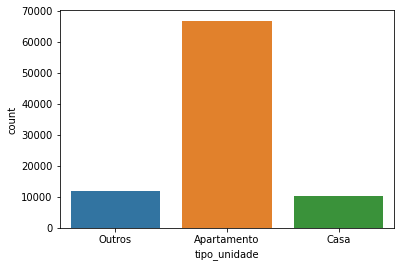

In [24]:
sns.barplot(data=tipo_unidadepd, x='tipo_unidade', y='count')

In [25]:
tipo_unidade_apart = imoveisRJ_anuncio_corr.filter("tipo_unidade == 'Apartamento'")
tipo_unidade_apart.show()

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    3|        43|       43|        1|[Academia, Churra...|{Paciência, 23585...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|[{245, null, Vend...|
|    2|        42|       42|        1|[Churrasqueira, P...|{Paciência, 23585...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|[{0, 0, Venda, 15...|
|    1|        41|       41|        1|[Portaria 24h, Co...|{Guaratiba, 23036...|18d22cbe-1b86-4

In [26]:
#Distribuição em tipo de uso
tipo_uso = imoveisRJ_anuncio_corr.groupBy("tipo_uso").count()
tipo_uso = tipo_uso.withColumn('count', tipo_uso['count'].cast(IntegerType()))
tipo_usopd = tipo_uso.toPandas()
tipo_usopd

,tipo_uso,count
0,Comercial,4542
1,Residencial,84541


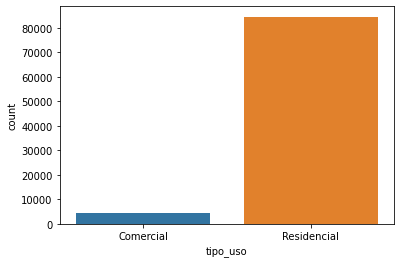

In [27]:
sns.barplot(data=tipo_usopd, x='tipo_uso', y='count')

In [28]:
tipo_uso_res = imoveisRJ_anuncio_corr.filter("tipo_uso == 'Residencial'")
tipo_uso_res.show()

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    0|       120|      120|        0|[Portão eletrônic...|{Campo Grande, 23...|ac6cb348-69d6-45a...|      0|  null|       Usado|      Outros|Residencial|null|[{80, null, Venda...|
|    0|         3|        3|        0|                  []|{São Cristóvão, 2...|e032b908-ef42-4d4...|      0|  null|       Usado|      Outros|Residencial|null|[{0, 0, Venda, 50...|
|    3|        43|       43|        1|[Academia, Churra...|{Paciência, 23585...|d2e3a3aa-09b5-4

In [29]:
#Distribuição em tipo de anuncio
tipo_anuncio = imoveisRJ_anuncio_corr.groupBy("tipo_anuncio").count()
tipo_anuncio = tipo_anuncio.withColumn('count', tipo_anuncio['count'].cast(IntegerType()))
tipo_anunciopd = tipo_anuncio.toPandas()
tipo_anunciopd

,tipo_anuncio,count
0,Usado,88827
1,Lançamento,256


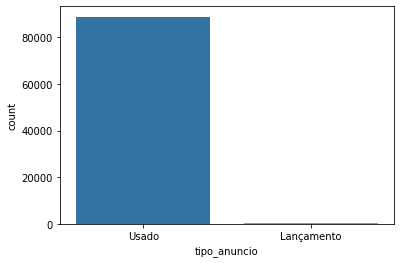

In [30]:
sns.barplot(data=tipo_anunciopd, x='tipo_anuncio', y='count')

In [31]:
tipo_uso_anun = imoveisRJ_anuncio_corr.filter("tipo_anuncio == 'Usado'")
tipo_uso_anun.show()

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    0|      null|       16|        0|                  []|{Centro, 20061003...|47d553e0-79f2-4a4...|      0|     0|       Usado|      Outros|  Comercial|   1|[{260, 107, Venda...|
|    0|      null|       14|        0|                  []|{Centro, 20051040...|b6ffbae1-17f6-487...|      0|  null|       Usado|      Outros|  Comercial|   0|[{260, 107, Venda...|
|    0|      1026|     1026|        0|                  []|{Maria da Graça, ...|1fb030a5-9e3e-4

# Analisando as informações sobre localização

## Extraindo a coluna Bairros e Zona da coluna de endereços

In [136]:
# Filtrando apenas o bairro e zona nos endereços e armazenando em outro dataframe
imoveisRJ_anuncio_end = imoveisRJ_anuncio_corr.select(['id','endereco.bairro','endereco.zona'])
imoveisRJ_anuncio_end.show(truncate=False)

+------------------------------------+--------------+------------+
|id                                  |bairro        |zona        |
+------------------------------------+--------------+------------+
|47d553e0-79f2-4a46-9390-5a3c962740c2|Centro        |Zona Central|
|b6ffbae1-17f6-4870-9950-e998ac1c8d6a|Centro        |Zona Central|
|1fb030a5-9e3e-4a1d-93cd-cd2d8a215e11|Maria da Graça|Zona Norte  |
|ac6cb348-69d6-45af-9589-dc34099370d8|Campo Grande  |Zona Oeste  |
|e032b908-ef42-4d4a-8125-eba4792bacbe|São Cristóvão |Zona Norte  |
|df9cf0b8-b972-4334-88c9-87ef528806df|Centro        |Zona Central|
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|Paciência     |Zona Oeste  |
|085bab2c-87ad-452a-bd0f-8b1451509f84|Paciência     |Zona Oeste  |
|096ad966-dc36-47bf-8795-5604f078713a|Centro        |Zona Central|
|18d22cbe-1b86-4764-8def-70c615f15a61|Guaratiba     |Zona Oeste  |
|bed8a354-9317-4426-b27e-1c798f864271|Cosmos        |Zona Oeste  |
|b7d0fbd3-0b28-4203-b7d2-5a63b6f6f7aa|Centro        |Zona Cent

In [137]:
imoveisRJ_anuncio_end = imoveisRJ_anuncio_end.withColumnRenamed("id","id_endereco")

In [138]:
imoveisRJ_anuncio_end.show(truncate=False)

+------------------------------------+--------------+------------+
|id_endereco                         |bairro        |zona        |
+------------------------------------+--------------+------------+
|47d553e0-79f2-4a46-9390-5a3c962740c2|Centro        |Zona Central|
|b6ffbae1-17f6-4870-9950-e998ac1c8d6a|Centro        |Zona Central|
|1fb030a5-9e3e-4a1d-93cd-cd2d8a215e11|Maria da Graça|Zona Norte  |
|ac6cb348-69d6-45af-9589-dc34099370d8|Campo Grande  |Zona Oeste  |
|e032b908-ef42-4d4a-8125-eba4792bacbe|São Cristóvão |Zona Norte  |
|df9cf0b8-b972-4334-88c9-87ef528806df|Centro        |Zona Central|
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|Paciência     |Zona Oeste  |
|085bab2c-87ad-452a-bd0f-8b1451509f84|Paciência     |Zona Oeste  |
|096ad966-dc36-47bf-8795-5604f078713a|Centro        |Zona Central|
|18d22cbe-1b86-4764-8def-70c615f15a61|Guaratiba     |Zona Oeste  |
|bed8a354-9317-4426-b27e-1c798f864271|Cosmos        |Zona Oeste  |
|b7d0fbd3-0b28-4203-b7d2-5a63b6f6f7aa|Centro        |Zona Cent

In [139]:
#Retirando a coluna endereço do dataframe principal
imoveisRJ_anuncio_sem_end = imoveisRJ_anuncio_corr\
  .drop('endereco')\

In [140]:
imoveisRJ_anuncio_sem_end.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    0|      null|       16|        0|                  []|47d553e0-79f2-4a4...|      0|     0|       Usado|      Outros|  Comercial|   1|[{260, 107, Venda...|
|    0|      null|       14|        0|                  []|b6ffbae1-17f6-487...|      0|  null|       Usado|      Outros|  Comercial|   0|[{260, 107, Venda...|
|    0|      1026|     1026|        0|                  []|1fb030a5-9e3e-4a1...|      0|  null|       Usado|      Outros|  Comercial|   0|[{null, 1613, Ven...|
|    0|       120|      120|        0|[P

In [141]:
imoveisRj_anuncio_BZ = imoveisRJ_anuncio_sem_end.join(imoveisRJ_anuncio_end, imoveisRJ_anuncio_end.id_endereco == imoveisRJ_anuncio_sem_end.id, 'inner')


In [142]:
imoveisRj_anuncio_BZ = imoveisRj_anuncio_BZ\
  .drop('id_endereco')


In [143]:
imoveisRj_anuncio_BZ.show(truncate=False)

+-----+----------+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-----------+----+-----------------------------------------------------+-----------------------+----------+
|andar|area_total|area_util|banheiros|caracteristicas                                                                                                                                   |id                                  |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|valores                                              |bairro                 |zona      |
+-----+----------+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+----------

## Extraindo as colunas de inforamações de valores e criando colunas separadas

In [144]:
imoveisRj_anuncio_BZ.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- valores: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- condominio: string (nullable = true)
 |    |    |-- iptu: string (nullable = true)
 |    |    |-- tipo: string (nullable = true)
 |    |    |-- valor: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)



In [145]:
# Filtrando apenas as colunas condomínio, iptu, tipo,valor no array de valores
imoveisRJ_anuncio_Valores = imoveisRj_anuncio_BZ.select(['id','valores.condominio','valores.iptu','valores.tipo','valores.valor'])
imoveisRJ_anuncio_Valores.show(truncate=False)

+------------------------------------+----------+------+-------+-------+
|id                                  |condominio|iptu  |tipo   |valor  |
+------------------------------------+----------+------+-------+-------+
|47d553e0-79f2-4a46-9390-5a3c962740c2|[260]     |[107] |[Venda]|[10000]|
|b6ffbae1-17f6-4870-9950-e998ac1c8d6a|[260]     |[107] |[Venda]|[10000]|
|1fb030a5-9e3e-4a1d-93cd-cd2d8a215e11|[null]    |[1613]|[Venda]|[10000]|
|ac6cb348-69d6-45af-9589-dc34099370d8|[80]      |[null]|[Venda]|[10000]|
|e032b908-ef42-4d4a-8125-eba4792bacbe|[0]       |[0]   |[Venda]|[5000] |
|df9cf0b8-b972-4334-88c9-87ef528806df|[223]     |[87]  |[Venda]|[18500]|
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|[245]     |[null]|[Venda]|[15000]|
|085bab2c-87ad-452a-bd0f-8b1451509f84|[0]       |[0]   |[Venda]|[15000]|
|096ad966-dc36-47bf-8795-5604f078713a|[250]     |[null]|[Venda]|[20000]|
|18d22cbe-1b86-4764-8def-70c615f15a61|[0]       |[0]   |[Venda]|[20000]|
|bed8a354-9317-4426-b27e-1c798f864271|[285]     |[n

In [146]:
# Tranformando as variáveis de array para seu determinado tipo
colunas_corrigir_valores = ['condominio', 'iptu', 'tipo', 'valor']
imoveisRJ_anuncio_Valores = imoveisRJ_anuncio_Valores.select([f.col(c)[0].alias(c) if c in colunas_corrigir_valores else c for c in imoveisRJ_anuncio_Valores.columns])
imoveisRJ_anuncio_Valores.show()

+--------------------+----------+----+-----+-----+
|                  id|condominio|iptu| tipo|valor|
+--------------------+----------+----+-----+-----+
|47d553e0-79f2-4a4...|       260| 107|Venda|10000|
|b6ffbae1-17f6-487...|       260| 107|Venda|10000|
|1fb030a5-9e3e-4a1...|      null|1613|Venda|10000|
|ac6cb348-69d6-45a...|        80|null|Venda|10000|
|e032b908-ef42-4d4...|         0|   0|Venda| 5000|
|df9cf0b8-b972-433...|       223|  87|Venda|18500|
|d2e3a3aa-09b5-45a...|       245|null|Venda|15000|
|085bab2c-87ad-452...|         0|   0|Venda|15000|
|096ad966-dc36-47b...|       250|null|Venda|20000|
|18d22cbe-1b86-476...|         0|   0|Venda|20000|
|bed8a354-9317-442...|       285|null|Venda|20000|
|b7d0fbd3-0b28-420...|       200|  86|Venda|11500|
|c6571c11-166e-4a4...|       470|null|Venda|12000|
|46d5b560-205f-45f...|       294|  98|Venda|18000|
|db197997-00e6-4d6...|       684|null|Venda|15000|
|835d4338-4aa9-4e4...|         0| 120|Venda|20000|
|12a13315-d67f-48f...|       24

In [147]:
# renomeando a coluna 'id'
imoveisRJ_anuncio_Valores = imoveisRJ_anuncio_Valores.withColumnRenamed("id","id_valores")
imoveisRJ_anuncio_Valores.show(truncate=False)

+------------------------------------+----------+----+-----+-----+
|id_valores                          |condominio|iptu|tipo |valor|
+------------------------------------+----------+----+-----+-----+
|47d553e0-79f2-4a46-9390-5a3c962740c2|260       |107 |Venda|10000|
|b6ffbae1-17f6-4870-9950-e998ac1c8d6a|260       |107 |Venda|10000|
|1fb030a5-9e3e-4a1d-93cd-cd2d8a215e11|null      |1613|Venda|10000|
|ac6cb348-69d6-45af-9589-dc34099370d8|80        |null|Venda|10000|
|e032b908-ef42-4d4a-8125-eba4792bacbe|0         |0   |Venda|5000 |
|df9cf0b8-b972-4334-88c9-87ef528806df|223       |87  |Venda|18500|
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|245       |null|Venda|15000|
|085bab2c-87ad-452a-bd0f-8b1451509f84|0         |0   |Venda|15000|
|096ad966-dc36-47bf-8795-5604f078713a|250       |null|Venda|20000|
|18d22cbe-1b86-4764-8def-70c615f15a61|0         |0   |Venda|20000|
|bed8a354-9317-4426-b27e-1c798f864271|285       |null|Venda|20000|
|b7d0fbd3-0b28-4203-b7d2-5a63b6f6f7aa|200       |86  |Venda|11

In [148]:
imoveisRJ_anuncio_Valores.printSchema()

root
 |-- id_valores: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [149]:
# Corrigindo os tipos dados em cada coluna
imoveisRJ_anuncio_Valores = imoveisRJ_anuncio_Valores.withColumn('condominio', imoveisRJ_anuncio_Valores['condominio'].cast(DoubleType()))
imoveisRJ_anuncio_Valores = imoveisRJ_anuncio_Valores.withColumn('iptu', imoveisRJ_anuncio_Valores['iptu'].cast(DoubleType()))
imoveisRJ_anuncio_Valores = imoveisRJ_anuncio_Valores.withColumn('valor', imoveisRJ_anuncio_Valores['valor'].cast(DoubleType()))
imoveisRJ_anuncio_Valores.printSchema()

root
 |-- id_valores: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



In [153]:
# Unindo com DataFrame Principal
imoveisRj_anuncio_Valores_completo = imoveisRj_anuncio_BZ.join(imoveisRJ_anuncio_Valores, imoveisRJ_anuncio_Valores.id_valores == imoveisRj_anuncio_BZ.id, 'inner')

In [154]:
imoveisRj_anuncio_Valores_completo.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+--------------------+----------+--------------------+----------+------+-------+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|              bairro|      zona|          id_valores|condominio|  iptu|   tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+--------------------+----------+--------------------+----------+------+-------+---------+
|    0|       116|      116|        2|[Elevador, Academ...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|[{100, 100, Venda...|     Barra da Tijuca|Zona Oeste|006e2b19-f4de-450...|     100.0| 100.0|  Venda|3793260.0|
|   

In [156]:
# Retirando as colunas valores e id_valores
imoveisRj_anuncio_Valores_completo = imoveisRj_anuncio_Valores_completo\
  .drop('valores')\
  .drop('id_valores')

imoveisRj_anuncio_Valores_completo.show()


+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-------+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|  iptu|   tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-------+---------+
|    0|       116|      116|        2|[Elevador, Academ...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|     Barra da Tijuca|Zona Oeste|     100.0| 100.0|  Venda|3793260.0|
|    0|       143|      143|        4|[Churrasqueira, P...|011acce0-129f-4c2...|      4|     3|       Usado| Apartamento|Residencial|   1|         Jacarepaguá|Zona Oeste|  

## Analisando os tipo de negociação dos imoveis

In [192]:
imoveisRj_anuncio_Valores_completo.groupby('tipo').count().show()

+-------+-----+
|   tipo|count|
+-------+-----+
|Aluguel|  811|
|  Venda|88272|
+-------+-----+



In [193]:
imoveisRj_anuncio_Valores_completo.filter(imoveisRJ_anuncio_Valores.tipo == "Venda").show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|  iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|    0|       116|      116|        2|[Elevador, Academ...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|     Barra da Tijuca|Zona Oeste|     100.0| 100.0|Venda|3793260.0|
|    0|       143|      143|        4|[Churrasqueira, P...|011acce0-129f-4c2...|      4|     3|       Usado| Apartamento|Residencial|   1|         Jacarepaguá|Zona Oeste|    3948.0

In [194]:
imoveisRj_anuncio_Valores_completo.filter(imoveisRJ_anuncio_Valores.tipo == "Aluguel").show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+-------+-------+-------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|        zona|condominio|   iptu|   tipo|  valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+-------+-------+-------+
|    0|        30|       30|        1|          [Elevador]|070bcd5b-8a55-440...|      0|     0|       Usado|      Outros|  Comercial|   1|     Barra da Tijuca|  Zona Oeste|     998.0|  385.0|Aluguel|  700.0|
|    0|       244|      244|        2|                  []|1d449b90-38fa-416...|      0|     0|       Usado|      Outros|  Comercial|   8|     Barra da Tijuca|  Zona Oe

In [195]:
imoveisRJ_anuncio_Valores_Venda = imoveisRj_anuncio_Valores_completo.filter(imoveisRJ_anuncio_Valores.tipo == "Venda")

In [196]:
imoveisRJ_anuncio_Valores_Venda.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|  iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|    0|       116|      116|        2|[Elevador, Academ...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|     Barra da Tijuca|Zona Oeste|     100.0| 100.0|Venda|3793260.0|
|    0|       143|      143|        4|[Churrasqueira, P...|011acce0-129f-4c2...|      4|     3|       Usado| Apartamento|Residencial|   1|         Jacarepaguá|Zona Oeste|    3948.0

## Salvando o DataFrame em um arquivo tipo parquet

In [165]:
#Salvando o arquivo
imoveisRJ_anuncio_Valores_Venda.write.parquet("imoveisRJ_tipo_venda.parquet")

In [167]:
# Teste de leitura para certificar a operação anterior
parquetFile = spark.read.parquet("imoveisRJ_tipo_venda.parquet")
parquetFile.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|   iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|    2|       270|      155|        3|[Condomínio fecha...|00406835-540c-4fb...|      3|     1|       Usado|        Casa|Residencial|   2|                Anil|Zona Oeste|     401.0| 1600.0|Venda| 950000.0|
|   11|       166|      166|        5|[Academia, Churra...|00790b85-56e3-43a...|      4|     4|       Usado| Apartamento|Residencial|   2|         Jacarepaguá|Zona Oeste|    21

## Salvando o DataFrame e um arquivo tipo csv

In [216]:
from pyspark.sql import Column

In [203]:
imoveisRJ_anuncio_Valores_Venda.show(1)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|         bairro|      zona|condominio| iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+---------+
|    0|       116|      116|        2|[Elevador, Academ...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|Barra da Tijuca|Zona Oeste|     100.0|100.0|Venda|3793260.0|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+---------+
only 

In [198]:
imoveisRJ_anuncio_Valores_Venda.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



In [204]:
imoveisRJ_anuncio_Valores_Venda.count()

88272

In [218]:
# Transformando a coluna 'caracteristicas' de Array para String
imoveisRJ_anuncio_Valores_Venda_csv = imoveisRJ_anuncio_Valores_Venda.withColumn('caracteristicas', concat_ws(",",col("caracteristicas")))

In [221]:
imoveisRJ_anuncio_Valores_Venda_csv.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: string (nullable = false)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



In [219]:
imoveisRJ_anuncio_Valores_Venda_csv.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|  iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+------+-----+---------+
|    0|       116|      116|        2|Elevador,Academia...|006e2b19-f4de-450...|      3|     1|       Usado| Apartamento|Residencial|   1|     Barra da Tijuca|Zona Oeste|     100.0| 100.0|Venda|3793260.0|
|    0|       143|      143|        4|Churrasqueira,Pis...|011acce0-129f-4c2...|      4|     3|       Usado| Apartamento|Residencial|   1|         Jacarepaguá|Zona Oeste|    3948.0

In [220]:
imoveisRJ_anuncio_Valores_Venda_csv.count()

88272

In [222]:
#Salvando o arquivo
imoveisRJ_anuncio_Valores_Venda_csv.write.option("header",True).csv("imoveisRJ_tipo_venda.csv")

In [225]:
# Teste de leitura para certificar a operação anterior
csvFile = spark.read.option("header",True).csv("imoveisRJ_tipo_venda.csv")
csvFile.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|   iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|    2|       270|      155|        3|Condomínio fechad...|00406835-540c-4fb...|      3|     1|       Usado|        Casa|Residencial|   2|                Anil|Zona Oeste|     401.0| 1600.0|Venda| 950000.0|
|   11|       166|      166|        5|Academia,Churrasq...|00790b85-56e3-43a...|      4|     4|       Usado| Apartamento|Residencial|   2|         Jacarepaguá|Zona Oeste|    21

## Comparando o tempo de leitura dos arquivos .parquet e .csv

In [226]:
# Arquivo .parquet
%%time

parquetFile = spark.read.parquet("imoveisRJ_tipo_venda.parquet")
parquetFile.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|   iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|    2|       270|      155|        3|[Condomínio fecha...|00406835-540c-4fb...|      3|     1|       Usado|        Casa|Residencial|   2|                Anil|Zona Oeste|     401.0| 1600.0|Venda| 950000.0|
|   11|       166|      166|        5|[Academia, Churra...|00790b85-56e3-43a...|      4|     4|       Usado| Apartamento|Residencial|   2|         Jacarepaguá|Zona Oeste|    21

In [227]:
# Arquivo .csv
%%time

csvFile = spark.read.option("header",True).csv("imoveisRJ_tipo_venda.csv")
csvFile.show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|      zona|condominio|   iptu| tipo|    valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+----------+----------+-------+-----+---------+
|    2|       270|      155|        3|Condomínio fechad...|00406835-540c-4fb...|      3|     1|       Usado|        Casa|Residencial|   2|                Anil|Zona Oeste|     401.0| 1600.0|Venda| 950000.0|
|   11|       166|      166|        5|Academia,Churrasq...|00790b85-56e3-43a...|      4|     4|       Usado| Apartamento|Residencial|   2|         Jacarepaguá|Zona Oeste|    21